# Darts ETS model

In [1]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts import metrics
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode
from darts.dataprocessing.transformers import Scaler

import matplotlib.pyplot as plt

/scale_wlg_persistent/filesets/project/nesi99999/riom/LSTM-ML-for-teeth/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
dset = pd.read_csv("../results/dataset_minutes.csv")
dset

,material,sample,Time [min],Line Distance [m],Wear Loss [mm]
0,G1,S1,0,0.118,-0.001950
1,G1,S1,1,0.358,-0.000967
2,G1,S1,2,0.598,-0.001717
3,G1,S1,3,0.838,-0.000992
4,G1,S1,4,1.078,-0.001683
...,...,...,...,...,...
236802,G9,S5,4162,998.998,0.162267
236803,G9,S5,4163,999.238,0.164275
236804,G9,S5,4164,999.478,0.163733
236805,G9,S5,4165,999.718,0.163325


In [3]:
material = "G10"
sample = "S3"
train_ratio = 0.6

In [4]:
def prepare_col(dset, col):
    serie = TimeSeries.from_dataframe(dset, time_col="Time [min]", value_cols=col)
    return serie.astype(np.float32)

In [5]:
dset_sample = dset[(dset["material"] == material) & (dset["sample"] == sample)]
serie_wear = prepare_col(dset_sample, "Wear Loss [mm]")
serie_train, serie_test = serie_wear.split_after(train_ratio)

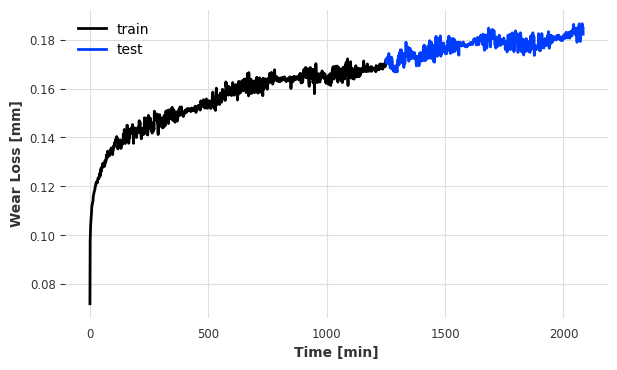

In [6]:
_, ax = plt.subplots(figsize=(7, 4))
serie_train.plot(label="train", ax=ax)
serie_test.plot(label="test", ax=ax)
_ = ax.set_ylabel("Wear Loss [mm]")

In [7]:
scaler = Scaler()
serie_train_scaled = scaler.fit_transform(serie_train)

## Model training

In [8]:
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=None)

In [9]:
model.fit(serie_train_scaled)

## Predictions

In [10]:
serie_forecast_scaled = model.predict(len(serie_test))
serie_forecast = scaler.inverse_transform(serie_forecast_scaled)

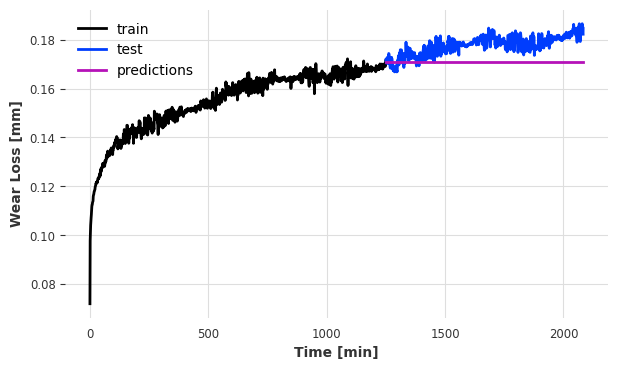

In [11]:
_, ax = plt.subplots(figsize=(7, 4))
serie_train.plot(label="train", ax=ax)
serie_test.plot(label="test", ax=ax)
serie_forecast.plot(label="predictions", ax=ax)
_ = ax.set_ylabel("Wear Loss [mm]")

We compute errors between observation and predictions but only at the **end point** of the trace.

In [12]:
scores_functions = {
    "MAE": metrics.mae,
    "RMSE": metrics.rmse,
    "MAPE": metrics.mape,
}

In [13]:
scores = {
    key: func(serie_test[-1], serie_forecast[-1])
    for key, func in scores_functions.items()
}
scores = (
    pd.DataFrame.from_dict(scores, orient="index", columns=("value",))
    .reset_index()
    .rename(columns={"index": "metric"})
)

In [14]:
scores

,metric,value
0,MAE,0.011439
1,RMSE,0.011439
2,MAPE,6.275940
